In [1]:
import pandas as pd
import os

dataset_path = '/kaggle/input/rockpaperscissors/rps-cv-images'

images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
        
df = pd.DataFrame({'image': images, 'label': labels})

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split dataset into train and val
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_dir = "/kaggle/input/rockpaperscissors"

datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 40, # Rotates a image rnadomly either 40% right or left
    width_shift_range = 0.2, # Shifting the image horizontally(left or right) by up to 20%
    height_shift_range = 0.2, # Shifting the image vertically(up or down) by up to 20%
    shear_range = 0.2, # Cropping the image by up to 20%
    zoom_range = 0.2, # Zooming the image by up to 20%,
    horizontal_flip = True, # horizontal flipping randomly
    fill_mode = 'nearest',
    validation_split = 0.2
)

train_gen = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size = (150, 150),
    class_mode = "categorical",
    subset = ("training")
)

valid_gen = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size = (150, 150),
    class_mode = "categorical",
    subset = ("validation")
)

test_datagen = ImageDataGenerator(
    rescale = 1/255
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size = (150, 150),
    class_mode = "categorical"
)

2024-06-01 06:31:29.017256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 06:31:29.017313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 06:31:29.018904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1400 validated image filenames belonging to 3 classes.
Found 350 validated image filenames belonging to 3 classes.
Found 438 validated image filenames belonging to 3 classes.


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True
)

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(64, (3,3), activation = "relu", input_shape = (150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation = "relu"),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation = "relu"),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation = "relu"),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(512, activation = "relu"),
    Dropout(0.3),
    Dense(3, activation = "softmax")
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.compile(
    optimizer = "rmsprop",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [7]:
history = model.fit(
    train_gen,
    epochs = 25,
    callbacks = [early_stopping],
    validation_data = valid_gen,
    verbose = 1
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3165 - loss: 1.1031 - val_accuracy: 0.3200 - val_loss: 1.0960
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.3692 - loss: 1.0996 - val_accuracy: 0.5257 - val_loss: 1.0315
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5170 - loss: 1.0306 - val_accuracy: 0.5400 - val_loss: 0.9663
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6441 - loss: 0.8181 - val_accuracy: 0.6829 - val_loss: 0.6696
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7136 - loss: 0.6776 - val_accuracy: 0.8000 - val_loss: 0.5210
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7619 - loss: 0.5930 - val_accuracy: 0.8400 - val_loss: 0.4276
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7618 - loss: 0.5654 - val_accuracy: 0.8143 - val_loss: 0.4319
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8053 - loss: 0.5022 - val_accuracy: 0.8686 - val_loss: 0.3742
Epo

Maximum validation accuracy: 0.9685714244842529


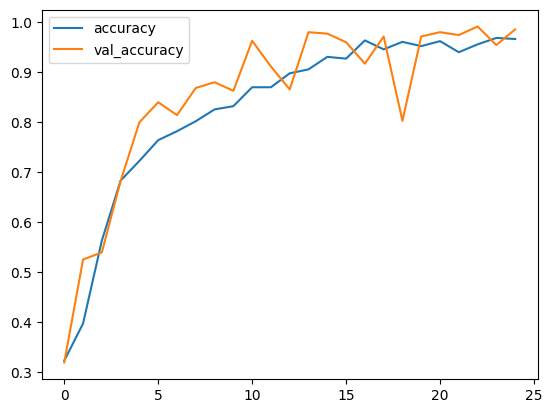

In [8]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print("Maximum validation accuracy: {}".format(history_df['accuracy'].max()))

In [9]:
model.evaluate_generator(test_gen, 400)

AttributeError: 'Sequential' object has no attribute 'evaluate_generator'